<h1> Cats and Dogs classification</h1>

This project chooses option 2 of cats and dogs classification

We have designed an algorithm based on Resnet50 and tuned it to the cats and dogs dataset

<h2> Imports and Constants </h2>

In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
import shutil
import random
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense  # Layers used in the model

#Constants

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

This cell can be ignored if you are not running on google collab and your dataset is based on local files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We created a function to create a subset folder of the train and validation images folder, you can adjust the number as needed.

Change the directory/path of your train, validation, test images folders depends on where you are running. (This is running on google collab thus the directory is based on google drive)

In [ ]:
# Paths to the original directories
original_train_dir = 'drive/MyDrive/datasets/train'
original_val_dir = 'drive/MyDrive/datasets/val'

# Paths to the subset directories
subset_train_dir = 'drive/MyDrive/datasets/train_subset'
subset_val_dir = 'drive/MyDrive/datasets/val_subset'

# Desired number of samples
num_train_samples = 5000
num_val_samples = 1000

# Function to create a subset directory with a random selection of images
def create_subset(original_dir, subset_dir, num_samples):
    # Create the subset directory if it doesn’t exist
    if not os.path.exists(subset_dir):
        os.makedirs(subset_dir)

    # Iterate over class subdirectories (e.g., 'class_0', 'class_1')
    for class_dir in os.listdir(original_dir):
        class_path = os.path.join(original_dir, class_dir)
        subset_class_path = os.path.join(subset_dir, class_dir)

        # Create class subdirectory in the subset directory
        if not os.path.exists(subset_class_path):
            os.makedirs(subset_class_path)

        # Randomly sample images from the class directory
        images = os.listdir(class_path)
        selected_images = random.sample(images, min(len(images), num_samples // len(os.listdir(original_dir))))

        # Copy selected images to the subset directory
        for img in selected_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(subset_class_path, img))

# Create subsets for training and validation directories
if not os.path.exists(subset_train_dir):
  create_subset(original_train_dir, subset_train_dir, num_train_samples)
if not os.path.exists(subset_val_dir):
  create_subset(original_val_dir, subset_val_dir, num_val_samples)

<h2>Data processing</h2>





In [ ]:
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Make sure to change your file directory based on which dataset you want to use, subset or full
train_dir = subset_train_dir #original_train_dir
val_dir = subset_val_dir #original_val_dir
test_dir = 'drive/MyDrive/datasets/test'

# Increase data augumentation for more robust training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest'
)



val_datagen = ImageDataGenerator(
    rescale = 1./255      # Normalizing pixel values to [0, 1]
)

# Raw pixel values in most images are stored as integers between 0 and 255 since they are typically 8 bit values
# By diving by 255, we normalize to range of [0,1]


train_generator = train_datagen.flow_from_directory(
    train_dir,                    # Path to the validation data directory
    shuffle = True,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,              # Batch size for validation
    class_mode='binary'         # For binary classification
)


val_generator = val_datagen.flow_from_directory(
    val_dir,                    # Path to the validation data directory
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,              # Batch size for validation
    class_mode='binary'         # For binary classification
)


Found 5000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


The following two cell is to investigate our validation and training dataset, we want to ensure that the dataset contains roughly an equvilalent amount of cats and dog images.

If there is unbalanced dataset we will need to implement the measures that are mentioned in the last question of the report.

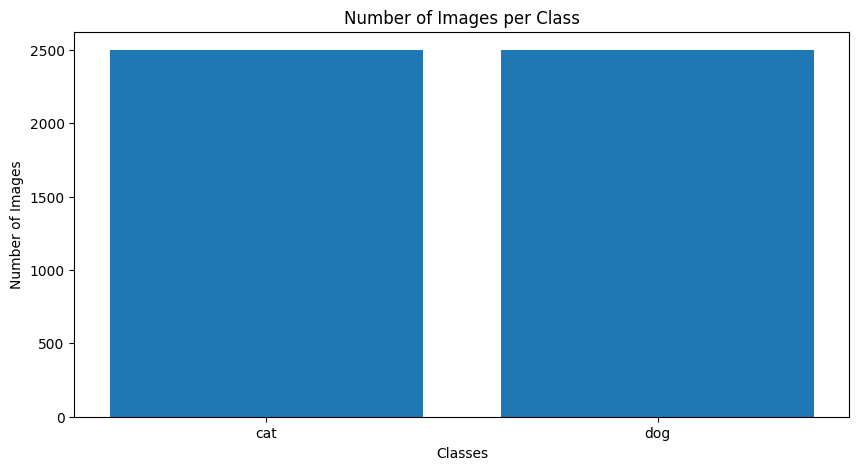

In [ ]:
class_counts = train_generator.classes
class_labels = list(train_generator.class_indices.keys())

images, labels = next(train_generator)

unique_classes, counts = np.unique(class_counts, return_counts=True)

# Create the bar plot
plt.figure(figsize=(10, 5))
plt.bar(class_labels, counts)
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Number of Images per Class")
plt.show()



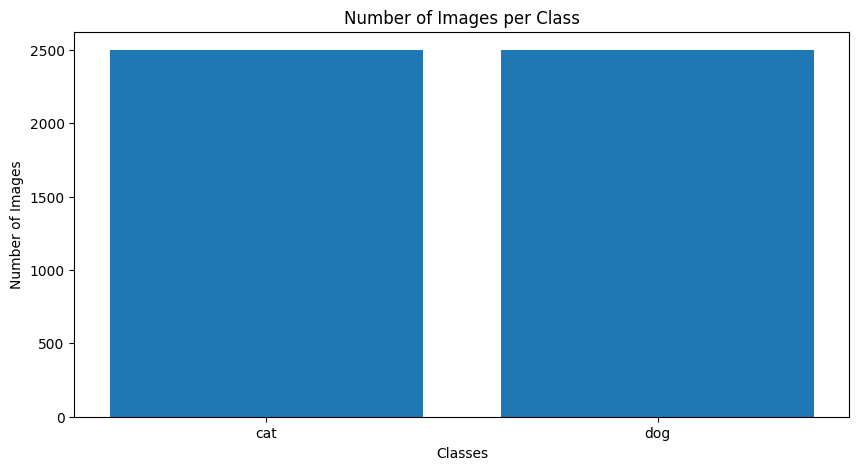

In [ ]:
images, labels = next(val_generator)

unique_classes, counts = np.unique(class_counts, return_counts=True)

# Create the bar plot
plt.figure(figsize=(10, 5))
plt.bar(class_labels, counts)
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Number of Images per Class")
plt.show()


<h2>Image Visualisation</h2>

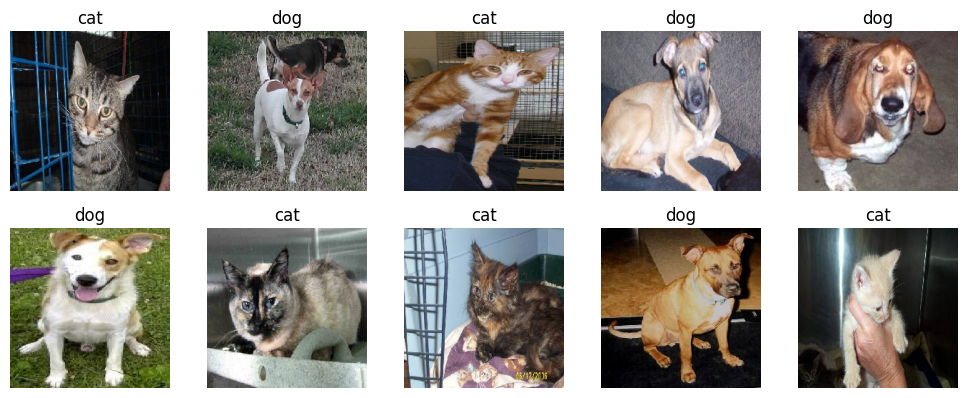

In [ ]:
# Set the number of images to display
num_images = 10
plt.figure(figsize=(10, 10))

# Display the images
for i in range(num_images):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    plt.title(class_labels[int(labels[i])])
    plt.axis('off')

plt.tight_layout()
plt.show()

<h2>Building the Model</h2>



<h1></h1>

In [ ]:
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense  # Layers used in the model

# Initialize ResNet50 layers with ImageNet weight (pre-trained)
base_model  = tf.keras.applications.resnet.ResNet50(
    include_top=False,
    input_shape = (224, 224, 3),
    weights='imagenet',
    pooling='max',
    classes=2,
)

# Freeze the base model layers
base_model.trainable = False


# Create a new model on top with adjusted layers and regularization
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.BatchNormalization()(x)  # Add Batch Normalization for stabilization
# # Add more dense layers with more units
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
# x = keras.layers.Dense(256, activation='relu')(x)
# x = keras.layers.Dropout(0.3)(x)
# x = keras.layers.Dense(128, activation='relu')(x)
# x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)

# Compile the model with a slightly lower learning rate
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Plot training and validation accuracy after the initial training
import matplotlib.pyplot as plt
def plot_accuracy(history):
    plt.figure(figsize=(8, 6))

    # Training and Validation Accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

    # Labeling the graph
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_loss(history):
    plt.figure(figsize=(8, 6))

    # Training and Validation Accuracy
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')

    # Labeling the graph
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

#Parameter Tuning Explanation and Strategies:

#1. Learning Rate:
#   - Initial learning rate (0.0001 in the example): Start with a low learning rate for initial training to prevent drastic weight changes.
#   - Fine-tuning learning rate (1e-5): Significantly lower learning rate for fine-tuning because we want to make smaller adjustments to the pre-trained weights.
#   - Tuning Strategy: Experiment with different learning rates. You can use learning rate schedules (e.g., reduce on plateau) or cyclical learning rates.

#2. Dropout Rate:
#   - Dropout (0.5 in the example) is a regularization technique that prevents overfitting by randomly dropping out neurons during training.
#   - Tuning Strategy: Experiment with different dropout rates (0.2, 0.3, 0.4, 0.5, 0.6) to find the best value for your model.

#3. Fine-tune at Layer:
#   - The 'fine_tune_at' parameter determines the number of layers in the base model to freeze during the initial training phase and those unfrozen for fine-tuning.
#   - Tuning Strategy: Experiment with different layer values. Start with freezing more layers and gradually unfreeze more as you progress.  Use the summary output to help identify which layers are good candidate.

#4. Number of Epochs:
#   - Epochs are the number of times the model sees the entire training dataset.
#   - Tuning Strategy: Monitor validation accuracy for overfitting. Stop training when validation accuracy plateaus or starts decreasing.


#5. Data Augmentation Parameters (in ImageDataGenerator):
#   - rotation_range, zoom_range, horizontal_flip, fill_mode, etc.
#   - Tuning Strategy: These parameters add randomness to the training data. Experiment with different settings to improve model robustness.  Too much augmentation could hurt training.

#6. Batch Size:
#   - The batch size affects the update frequency of the model's weights.
#   - Tuning Strategy: Typical batch sizes are 32 or 64, though others may work.  If there are not enough memory resources, the batch size must be lowered.


#General Tuning Strategies:
#  - Use a validation set: Monitor your model's performance on the validation set during training to detect overfitting.
#  - Cross-validation: If you have limited data, consider using k-fold cross-validation.
#  - Grid Search/Random Search: Systematically search over a range of hyperparameter values.
#  - Early Stopping: Stop training when validation performance no longer improves.

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


<h2> Training the Model </h2>

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


157/157 ━━━━━━━━━━━━━━━━━━━━ 4167s 25s/step - accuracy: 0.5719 - loss: 0.7315 - val_accuracy: 0.6350 - val_loss: 0.6329
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 79s 483ms/step - accuracy: 0.6021 - loss: 0.7036 - val_accuracy: 0.6590 - val_loss: 0.6173
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 486ms/step - accuracy: 0.6027 - loss: 0.7062 - val_accuracy: 0.7020 - val_loss: 0.6083
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 82s 501ms/step - accuracy: 0.6293 - loss: 0.6706 - val_accuracy: 0.6950 - val_loss: 0.6089
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 487ms/step - accuracy: 0.6054 - loss: 0.6908 - val_accuracy: 0.6870 - val_loss: 0.6207


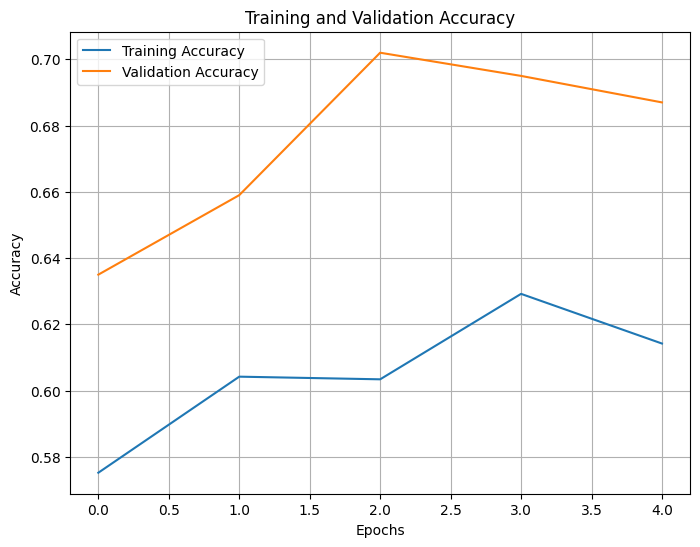

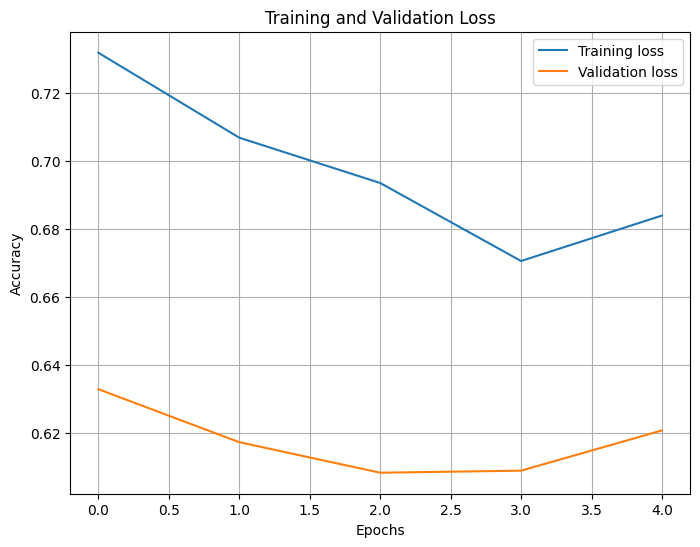

In [ ]:
# Initial training with frozen layers
epochs = 5  # Adjust as needed
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)

# Plot after initial training
plot_accuracy(history)
plot_loss(history)

Epoch 5/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 164s 676ms/step - accuracy: 0.8443 - loss: 0.3243 - val_accuracy: 0.5000 - val_loss: 11.1242 - learning_rate: 5.0000e-05
Epoch 6/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 79s 483ms/step - accuracy: 0.9618 - loss: 0.1075 - val_accuracy: 0.4930 - val_loss: 0.9065 - learning_rate: 5.0000e-05
Epoch 7/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 79s 482ms/step - accuracy: 0.9781 - loss: 0.0606 - val_accuracy: 0.5560 - val_loss: 0.7425 - learning_rate: 5.0000e-05
Epoch 8/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 79s 481ms/step - accuracy: 0.9780 - loss: 0.0559 - val_accuracy: 0.8050 - val_loss: 0.4802 - learning_rate: 5.0000e-05
Epoch 9/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 79s 485ms/step - accuracy: 0.9776 - loss: 0.0561 - val_accuracy: 0.9510 - val_loss: 0.1283 - learning_rate: 5.0000e-05
Epoch 10/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 79s 481ms/step - accuracy: 0.9794 - loss: 0.0500 - val_accuracy: 0.9790 - val_loss: 0.0861 - learning_rate: 5.0000e-05
Epoch 11/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 80

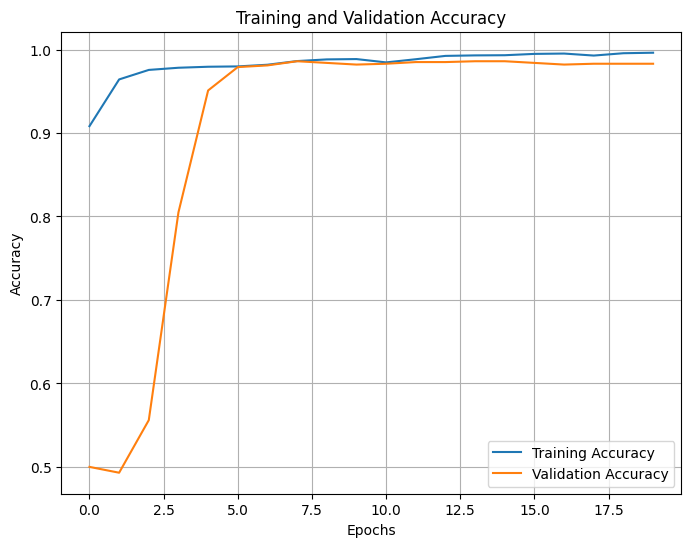

In [ ]:
# Fine tune the entire layer
base_model.trainable = True

# Recompile the model with a low learning rate for fine-tuning
model.compile(optimizer=keras.optimizers.Adam(learning_rate=5e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Learning rate scheduler and early stopping callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Continue training
fine_tune_epochs = 20 # Adjust as needed
total_epochs = epochs + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1], # Continue from previous epoch
    validation_data=val_generator,
    callbacks=[lr_scheduler, early_stop]  # Add learning rate scheduler and early stopping
)

# Plot after fine-tuning
plot_accuracy(history_fine)
plot_loss(history_fine)

<h2> Testing the model </h2>

<p>Please change the file path for submission.csv and testLabel.csv in the next cell if you are not running on google colab and connected to google drive</p>

In [ ]:
import pandas as pd
import os
from tensorflow import keras

# Load your trained model
testmodel  = history_fine

# Define the directory containing the test images
test_dir = 'drive/MyDrive/datasets/test'

# Create an empty list to store the results
results = []

# Iterate over the images in the test directory
for filename in os.listdir(test_dir):
    if filename.endswith(('.jpg', '.jpeg', '.png')):  # Check for image files
        image_path = os.path.join(test_dir, filename)

        # Load and preprocess the image
        img = keras.preprocessing.image.load_img(image_path, target_size=(224, 224))  # Adjust target_size if necessary
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.  # Normalize pixel values

        # Make the prediction
        prediction = model.predict(img_array)

        # Assuming binary classification, get the predicted class (0 or 1)
        predicted_class = class_labels[int(round(prediction[0][0]))]  # or np.argmax(prediction) for multi-class

        # Remove file extension
        filename_no_ext = os.path.splitext(filename)[0]

        # Append the results to the list
        results.append([filename_no_ext, predicted_class])

# Create a Pandas DataFrame from the results
df = pd.DataFrame(results, columns=['id', 'Label'])

# Save the DataFrame to a CSV file
df.to_csv('drive/MyDrive/submission.csv', index=False)

print("Predictions saved to submission.csv")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━

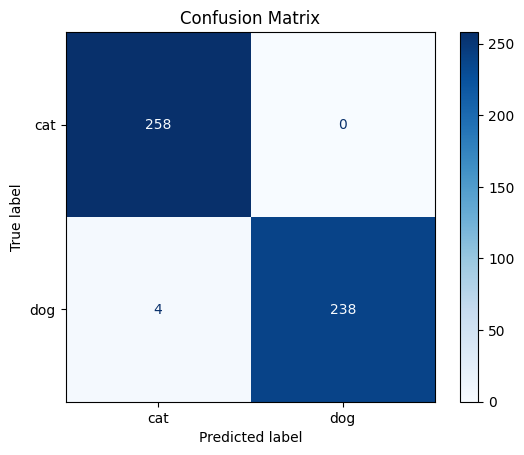

True Positives (TP): 238
False Positives (FP): 0
True Negatives (TN): 258
False Negatives (FN): 4


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the predicted labels
predictions_df = pd.read_csv('drive/MyDrive/submission.csv')
# Load the actual labels
actual_df = pd.read_csv('drive/MyDrive/testLabels.csv')

merged_df = pd.merge(predictions_df, actual_df, on='id')

y_pred = merged_df['Label']
y_true = merged_df['Actual']

cm = confusion_matrix(y_true, y_pred, labels=['dog', 'cat'])

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=['dog', 'cat'])

# Extract TP, FP, TN, FN from the confusion matrix
tn, fp, fn, tp = cm.ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y_true.unique()))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

<h2> Feature Map Extraction and investigating errors </h2>

<p>Please change the filepath for the images if not connected with Google Drive</p>

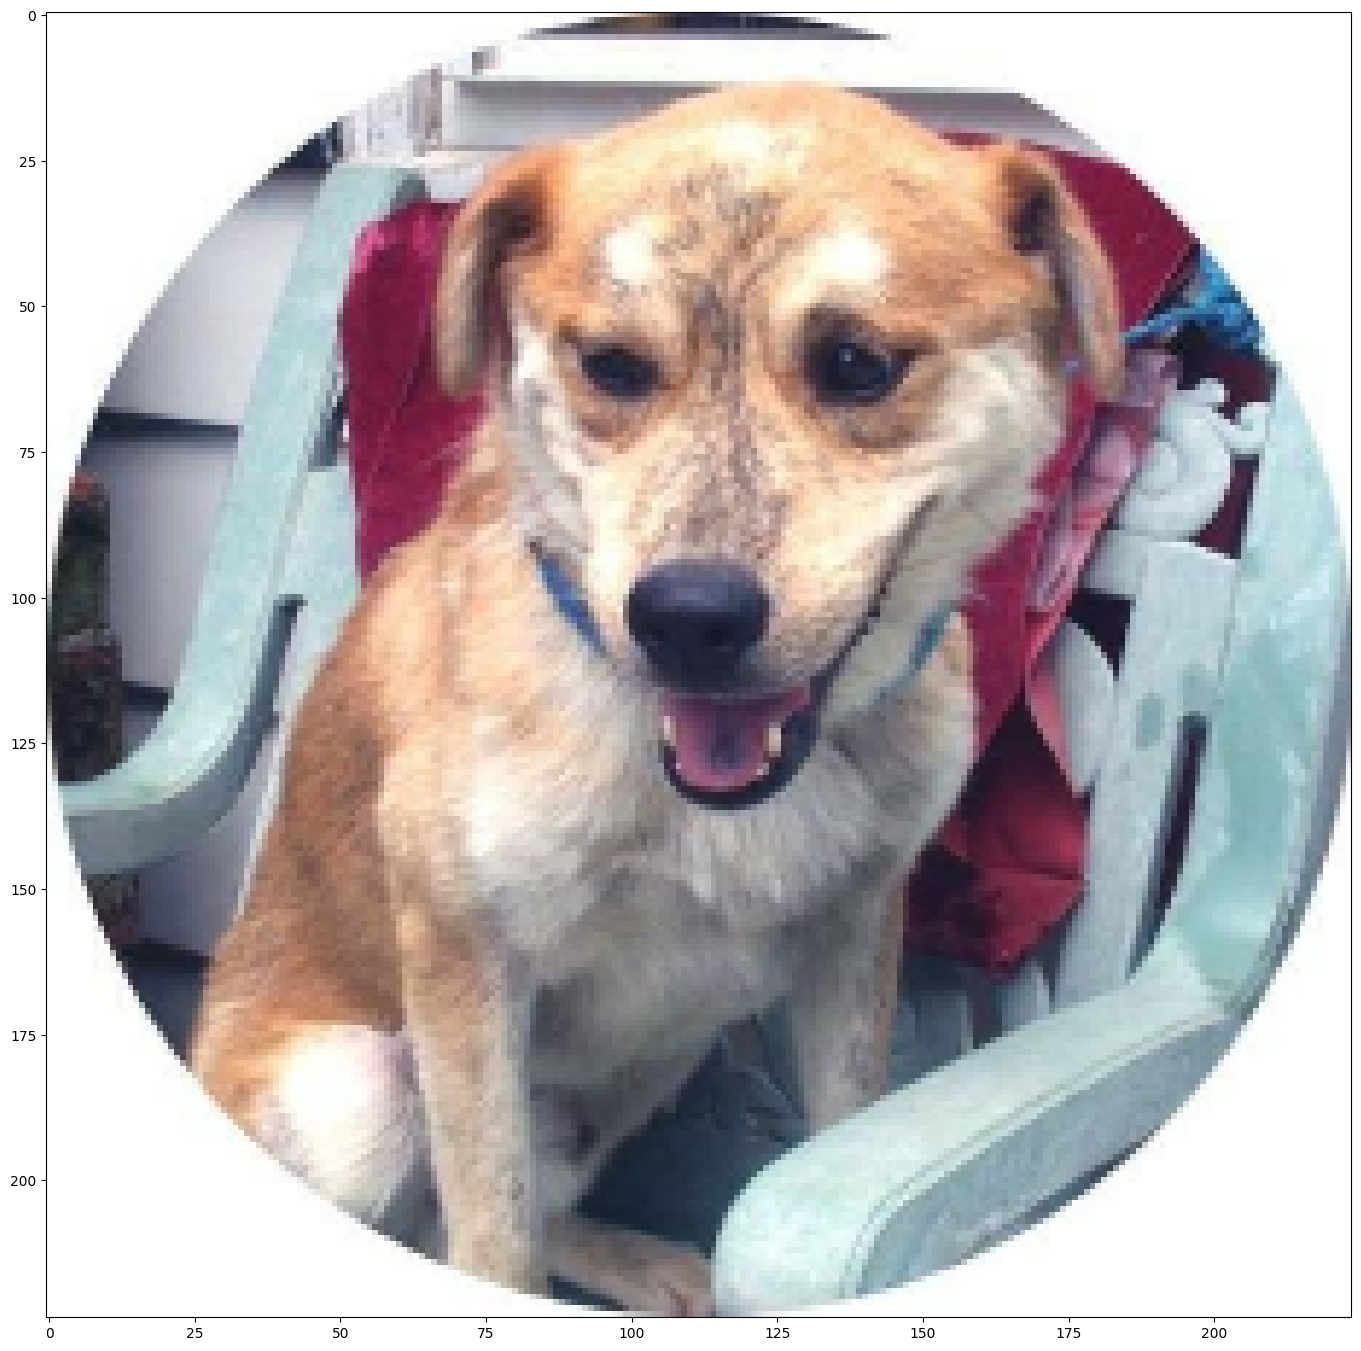

In [ ]:
import cv2
import PIL
import PIL.Image as Image

image_to_extract_pth = '/content/drive/MyDrive/datasets/test/320.jpg'

image_to_extract = Image.open(image_to_extract_pth)
image_to_extract = np.array(image_to_extract)
image_to_extract = tf.image.resize(image_to_extract, (224, 224))
image_to_extract = np.array(image_to_extract)
plt.figure(figsize=(200, 200))
ax = plt.subplot(10, 10, 1)
plt.imshow(image_to_extract.astype("int"))
image_to_extract = np.expand_dims(image_to_extract, axis=0)

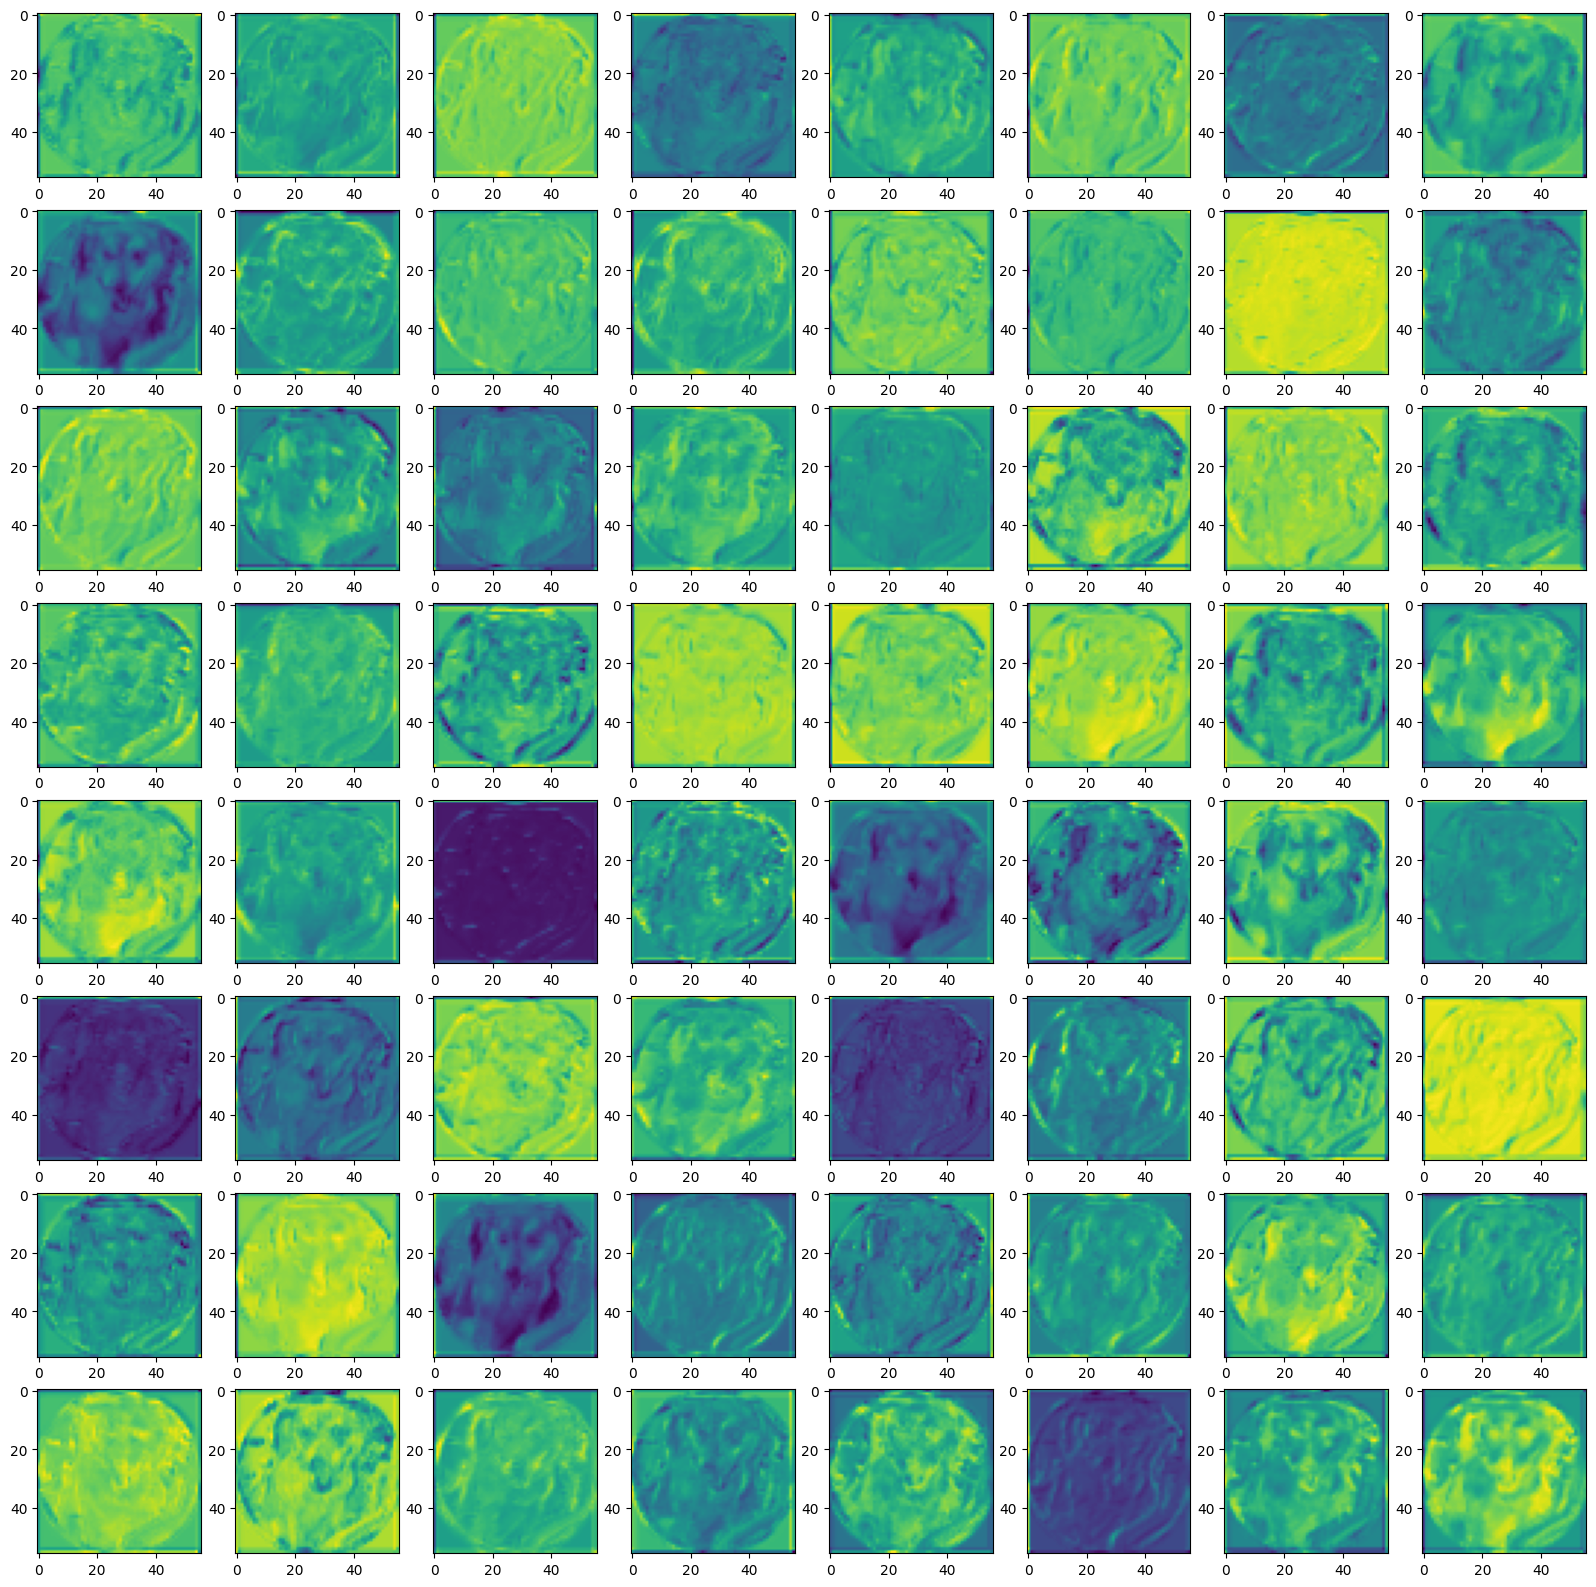

In [ ]:
model(image_to_extract)
feature_extractor = tf.keras.Sequential(model.layers[1].layers[0:14])
feature_extractor.build(input_shape = (None, 224, 224, 3))

feature_map = feature_extractor(image_to_extract)

plt.figure(figsize=(20,20))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(feature_map[0,:,:,i])
plt.show()

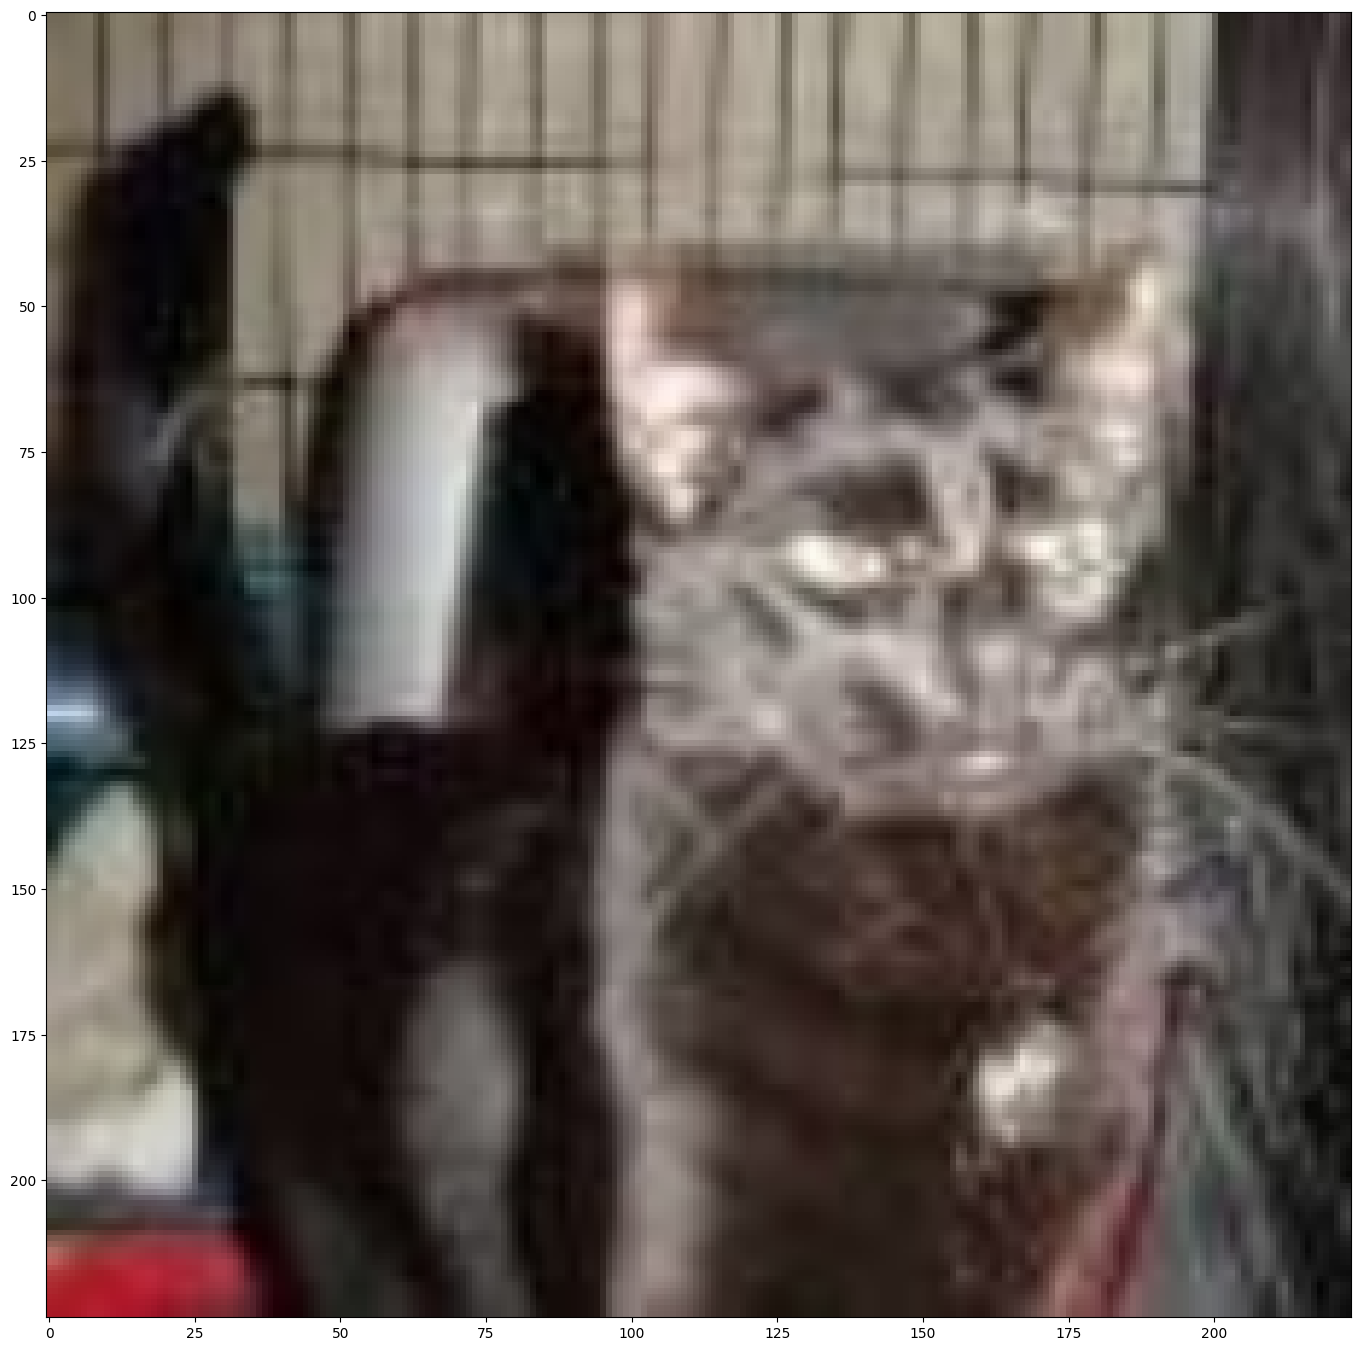

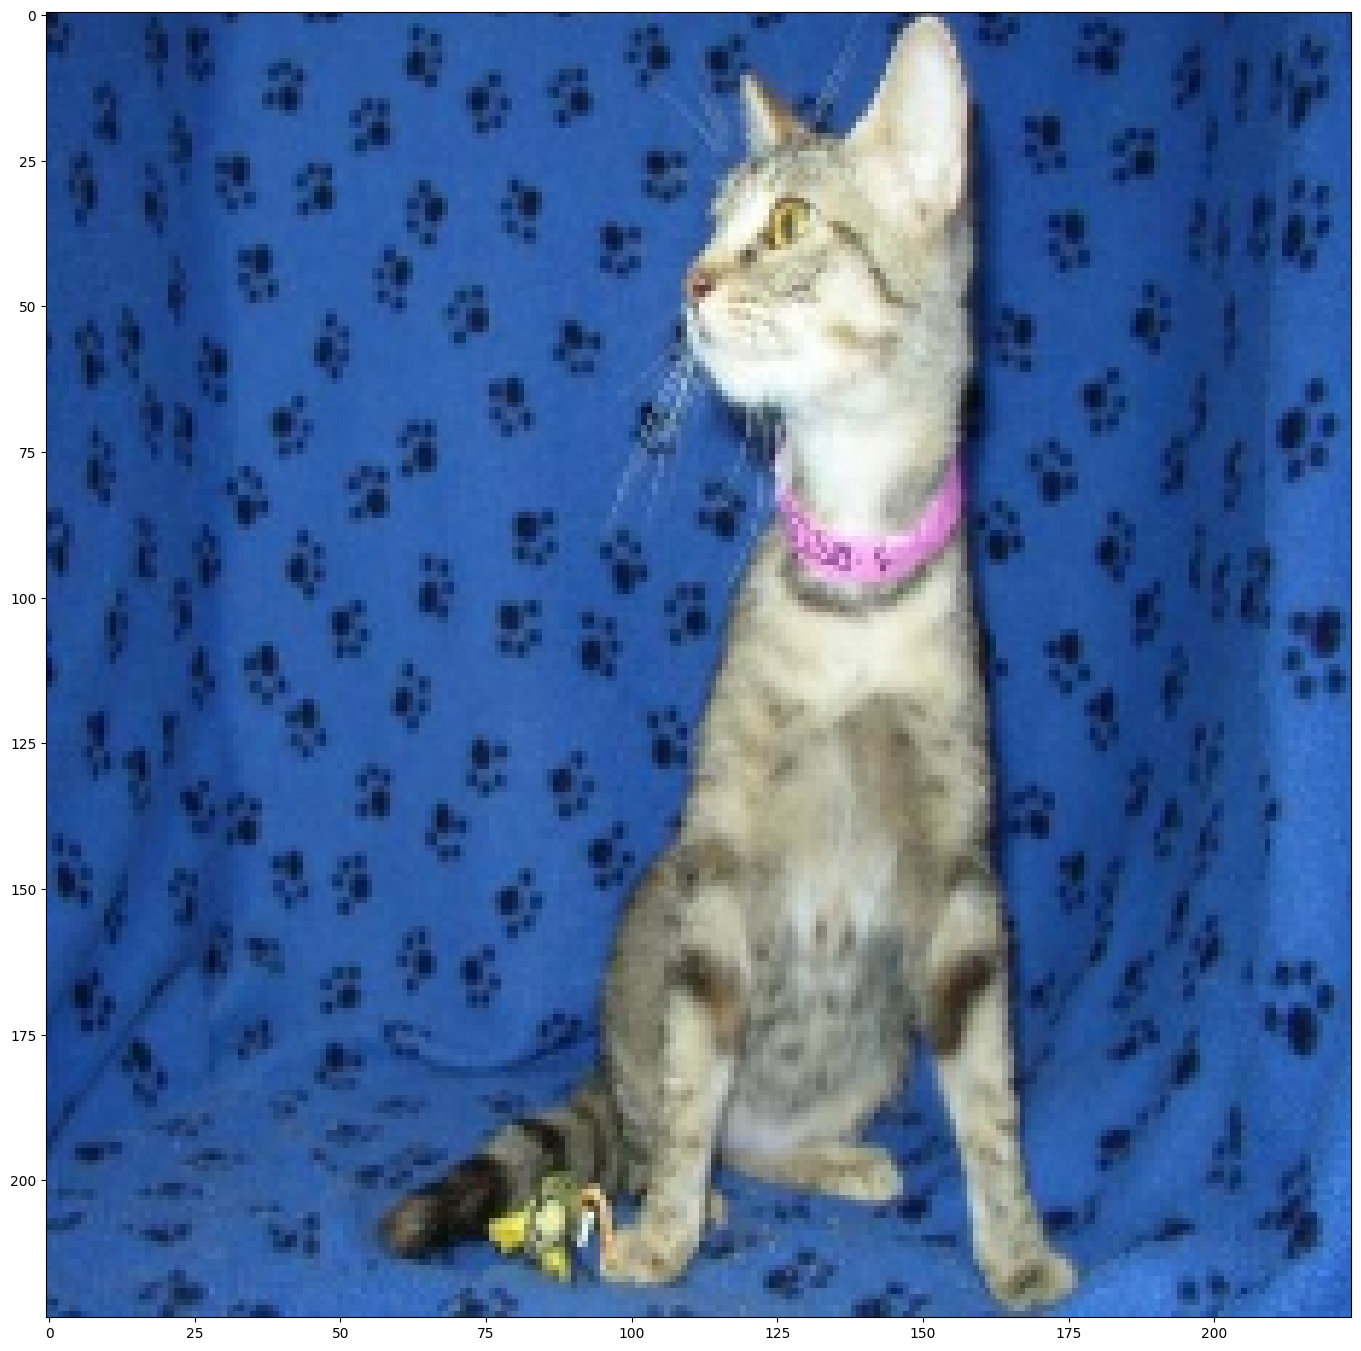

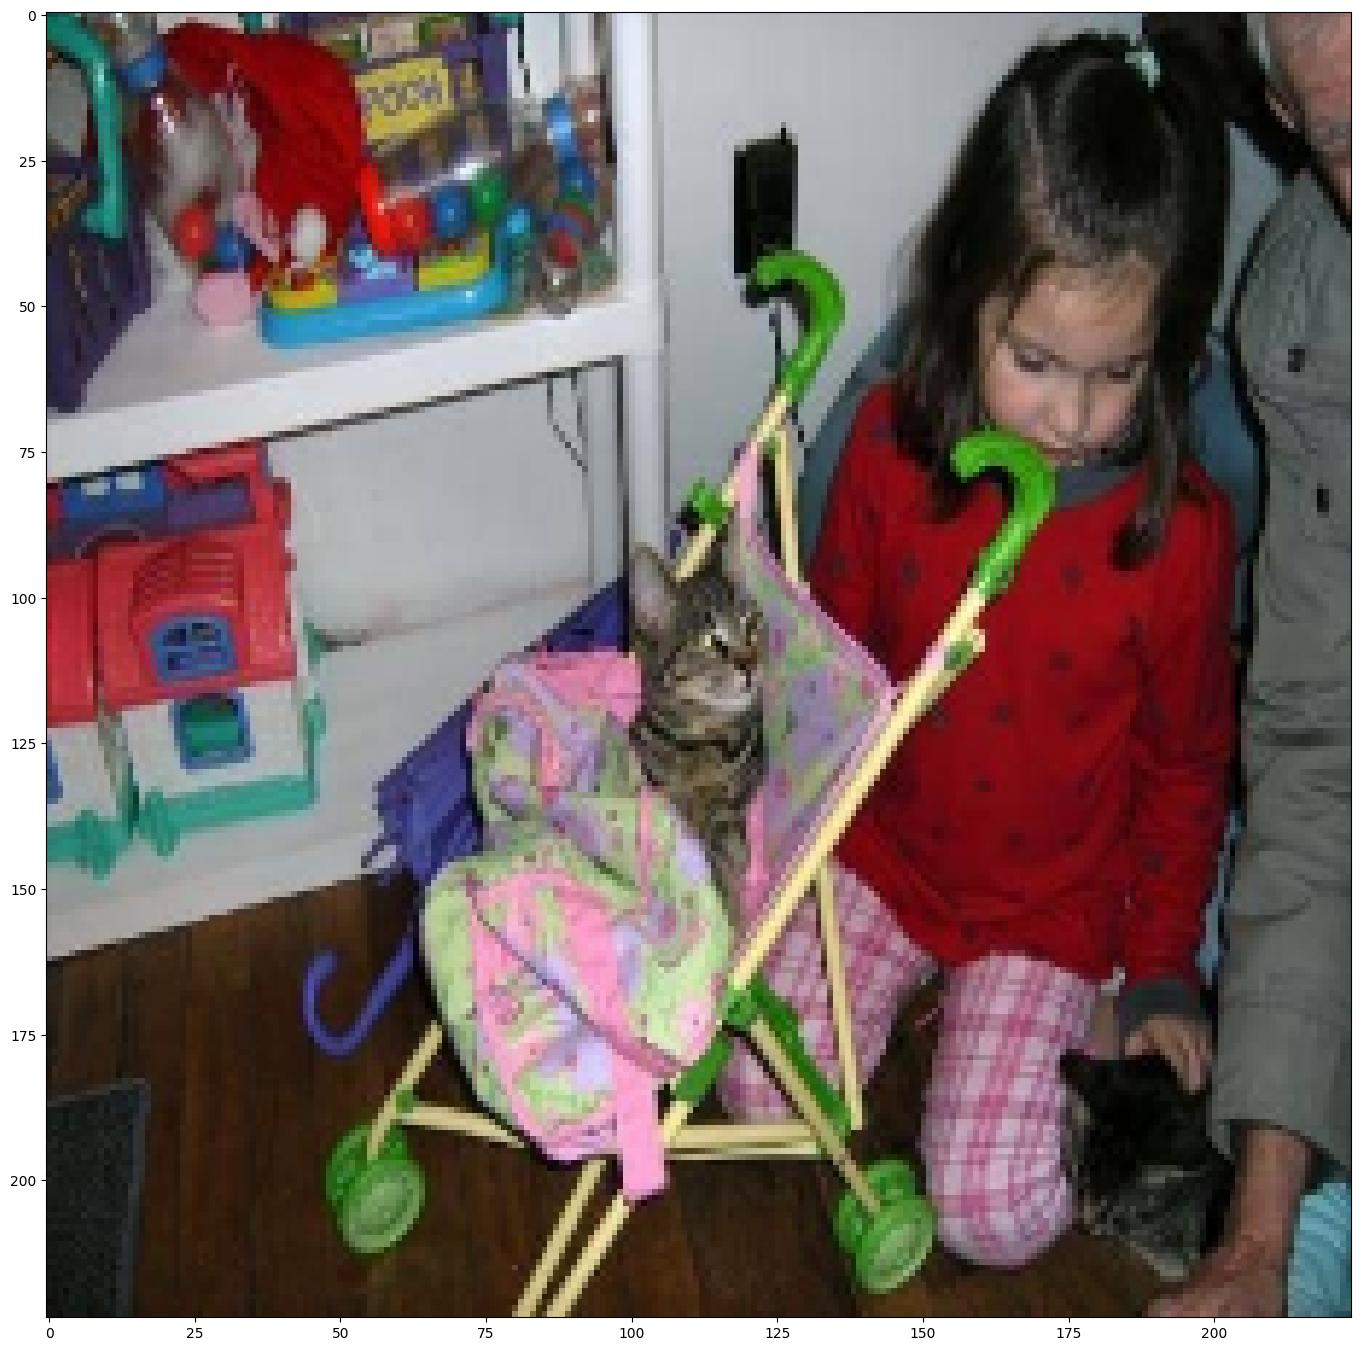

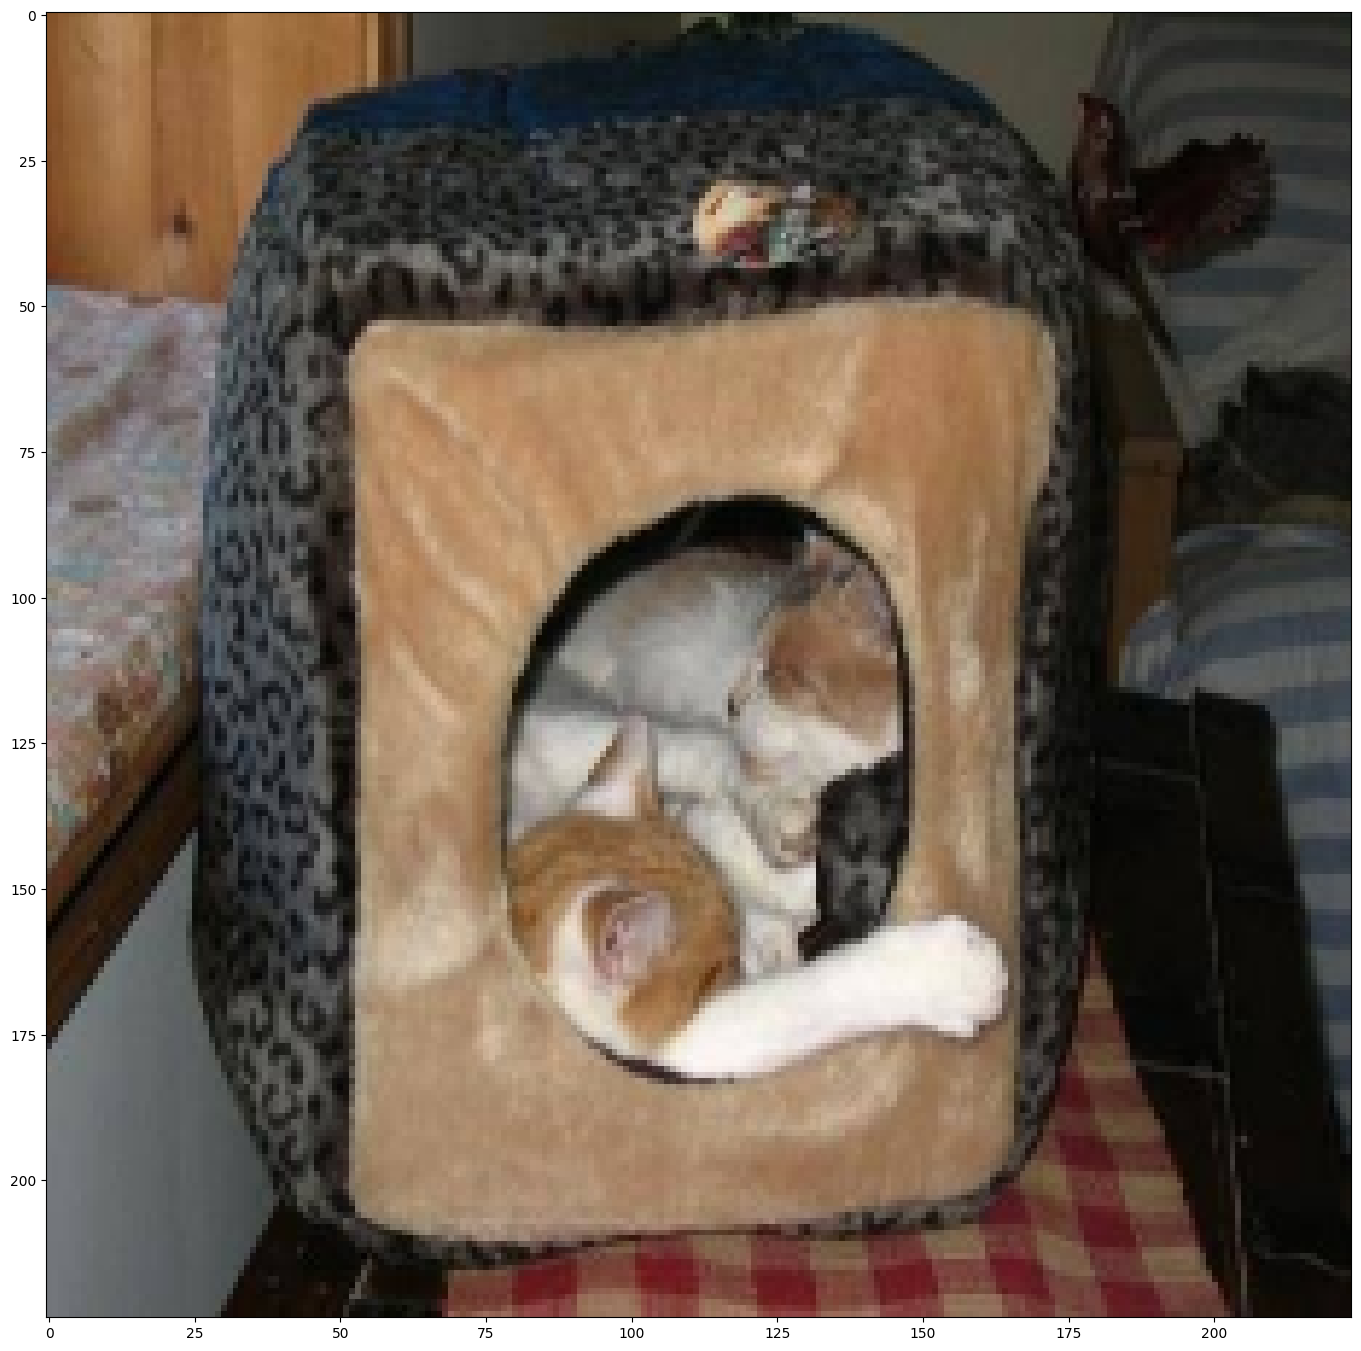

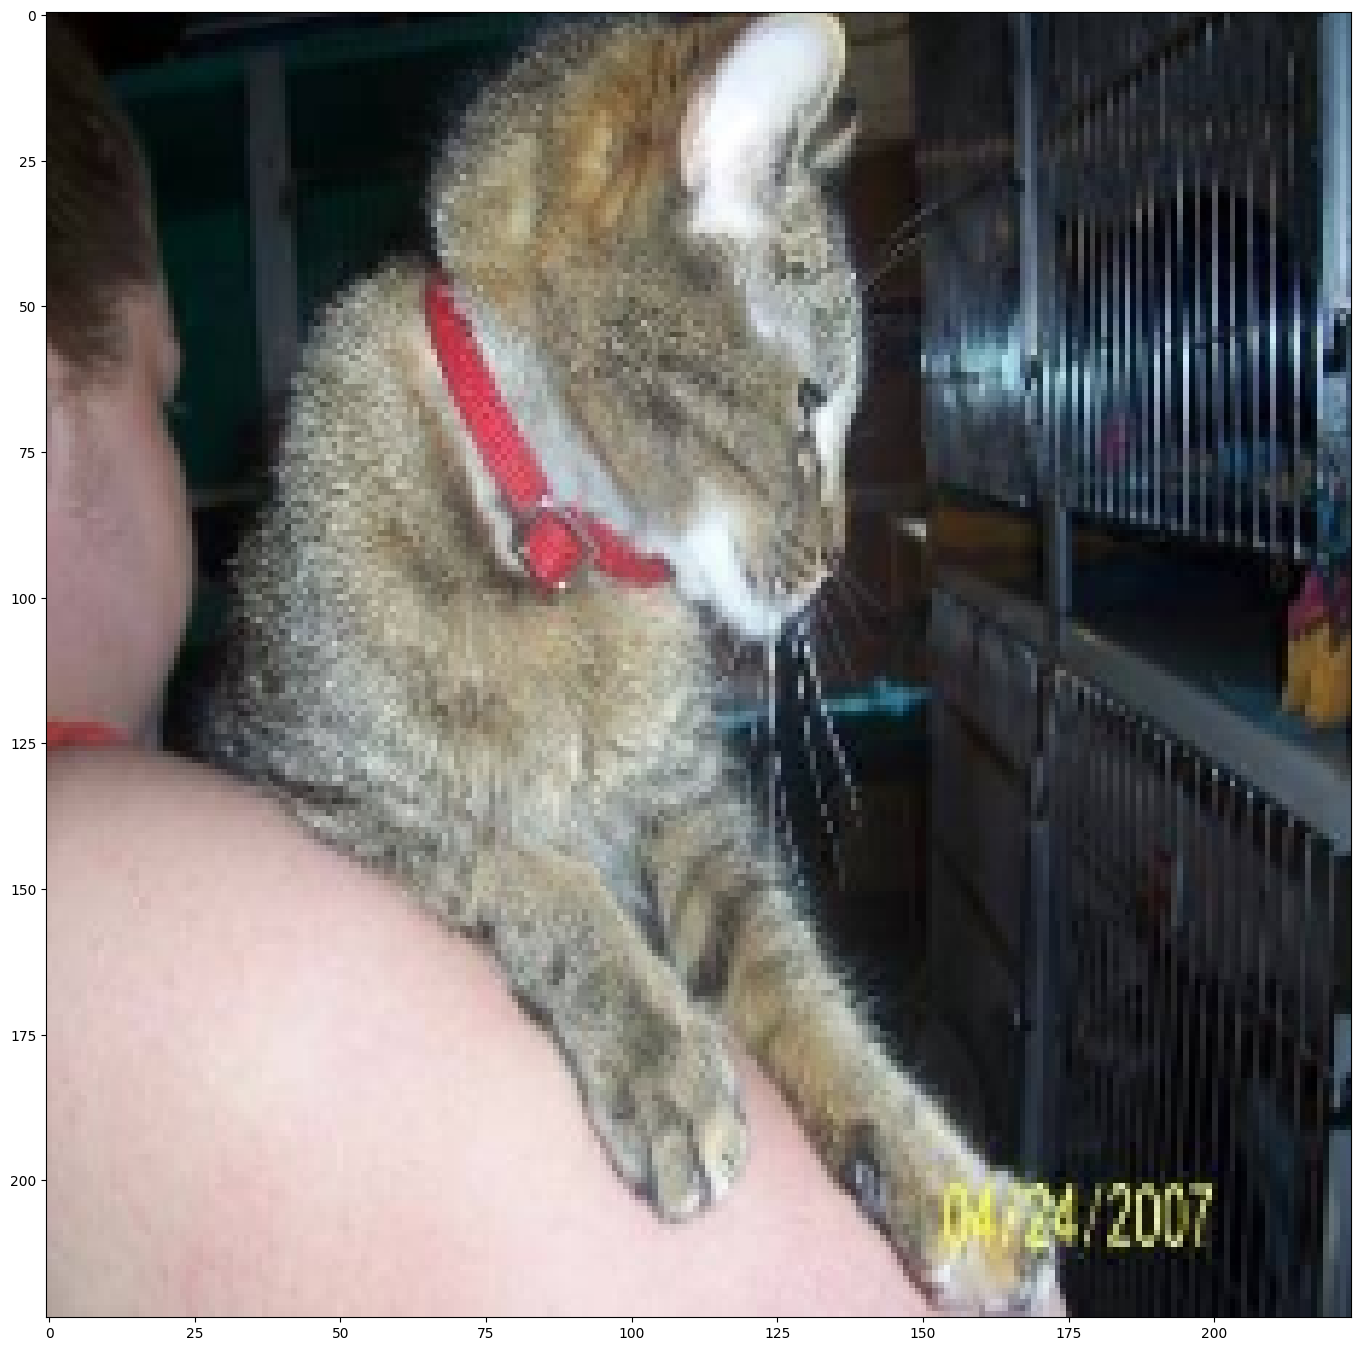

In [ ]:
dir = '/content/drive/MyDrive/datasets/test/'

error_image_arr = ['166.jpg', '291.jpg', '293.jpg', '374.jpg', '397.jpg']#'/content/drive/MyDrive/datasets/test/397.jpg'

for x in range(len(error_image_arr)):
  image_to_extract = Image.open(dir + error_image_arr[x])
  image_to_extract = np.array(image_to_extract)
  image_to_extract = tf.image.resize(image_to_extract, (224, 224))
  image_to_extract = np.array(image_to_extract)
  plt.figure(figsize=(200, 200))
  ax = plt.subplot(10, 10, 1)
  plt.imshow(image_to_extract.astype("int"))
  image_to_extract = np.expand_dims(image_to_extract, axis=0)

Model saving

In [ ]:
model.save('drive/MyDrive/model.h5')